### Edgar Moises Hernandez-Gonzalez
#### 05/06/20-06/06/20
#### Clasificacion de imagenes motoras en EEG con CNN-2D
##### Caracteristicas = Espectrogramas STFFT (3D)
##### Concatenacion vertical
##### Resize proporcional de 264x4
##### Sin Data Augmentation
## 5 ejecuciones independientes
##### 2 seg

In [0]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import cohen_kappa_score, confusion_matrix
from scipy.signal import spectrogram
import cv2
# from keras.utils import to_categorical
# from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
# from keras.callbacks import ModelCheckpoint
from keras import backend as K

Using TensorFlow backend.


In [2]:
# para que este script funcione debe de decir 'channels_last', si dice 'channels_first' no sirve
K.image_data_format()

'channels_last'

In [0]:
x_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/MI-EEG-A06T.csv", header=None)
x_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/MI-EEG-A06E.csv", header=None)
y_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/EtiquetasA06T.csv", header=None)
y_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/EtiquetasA06E.csv", header=None)

In [4]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(288, 22000)
(288, 22000)
(288, 1)
(288, 1)


In [5]:
n_samples_train = len(y_train)
n_samples_test = len(y_test) #en caso de no tener el y_test se puede utilizar el x_test

print("n_samples_train:", n_samples_train)
print("n_samples_test :", n_samples_test)

n_samples_train: 288
n_samples_test : 288


In [6]:
n_classes = len(np.unique(y_test)) #esto se podria calcular asi n_clases = len(np.unique(y)), la y puede ser train o test

print("n_classes:", n_classes)

n_classes: 4


In [7]:
#codificar etiquetas con valores de 0 a nClases-1
le = LabelEncoder().fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [0]:
# las etiquetas en categorical para poder entrenar data augmentation
# y_train_categorical = to_categorical(y_train)
# y_test_categorical = to_categorical(y_test)

In [0]:
#unir 22 canales y resize de tamaño proporcional
def unir_espectrogramas_vertical_resize(data):
  dim = (4, 264) #ancho, alto
  fs = 250
  datos = np.zeros((288,264,4))
  temporal = np.zeros((528,2))
  for i in range(data.shape[0]): #288 muestras
    for j in range(22): #22 canales
      sig = data.iloc[i, j*1000:(j+1)*1000]
      sig = sig[124:624]
      f, t, Sxx = spectrogram(sig, fs) #espectrograma de STFFT
      temporal[j*24:(j+1)*24, :] = Sxx[8:32, :]
    resized = cv2.resize(temporal, dim, interpolation=cv2.INTER_AREA)
    datos[i] = resized
    if i % 100 == 0: #esto solo es para ver como avanza
      print(i)
  return datos

In [10]:
#llamar a unir_espectrogramas_vertical_resize(data)
inicio = time.time()

x_train = unir_espectrogramas_vertical_resize(x_train)
x_test = unir_espectrogramas_vertical_resize(x_test)

fin = time.time()
print("Tiempo:", fin - inicio)

0
100
200
0
100
200
Tiempo: 8.57343602180481


In [11]:
print(x_train.shape)
print(x_test.shape)

(288, 264, 4)
(288, 264, 4)


In [12]:
print(np.max(x_train))
print(np.max(x_test))
print(np.min(x_train))
print(np.min(x_test))
print(np.mean(x_train))
print(np.mean(x_test))

216.60755916778774
157.668363553419
0.0007081454204163156
0.00045805550024795576
2.0308243577702463
1.9598160604037143


In [0]:
x = np.ceil(np.max(x_train))

In [0]:
#convertir a float
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#escalar los valores en un rango de 0 a 1 (normalizar)
x_train /= x
x_test /= x

In [15]:
print(np.max(x_train))
print(np.max(x_test))
print(np.min(x_train))
print(np.min(x_test))
print(np.mean(x_train))
print(np.mean(x_test))

0.99819154
0.72658235
3.263343e-06
2.110855e-06
0.009358639
0.009031409


In [16]:
#convertir de 3D a 4D
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))

print(x_train.shape)
print(x_test.shape)

(288, 264, 4, 1)
(288, 264, 4, 1)


In [0]:
# datagen_train = ImageDataGenerator(width_shift_range=0.25)

In [0]:
# usar el .hdf5
# mc = ModelCheckpoint('best.h5', monitor='val_accuracy', save_best_only=True)
#mc = ModelCheckpoint('/content/drive/My Drive/BCI-IV-2a/Modelos/Modelo_STFTDA09.hdf5',
#                     monitor='val_accuracy', save_best_only=True, verbose=1)

In [0]:
def CNN_2D():
  model = Sequential()
  model.add(Conv2D(16, (3,3), activation='relu', padding='same',
                   input_shape=x_train.shape[1:]))
  model.add(MaxPool2D((2,2)))
  model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
  model.add(MaxPool2D((2,2)))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(lr=1e-4)
  model.compile(optimizer = optimizer,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model

Iteration: 1
loss:  1.6184976763195462
accuracy:  0.4375
kappa:  0.25
confusion matrix:
 [[38 21  7  6]
 [20 31 16  5]
 [21  8 32 11]
 [16 16 15 25]]


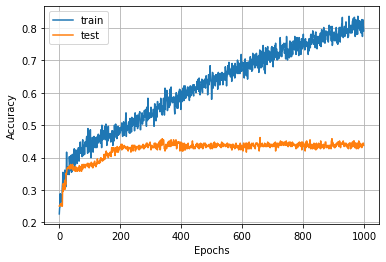

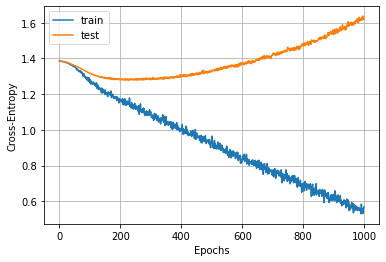

Iteration: 2
loss:  1.6936448282665677
accuracy:  0.4375
kappa:  0.25
confusion matrix:
 [[36 21  6  9]
 [21 29 21  1]
 [22  5 31 14]
 [20 15  7 30]]


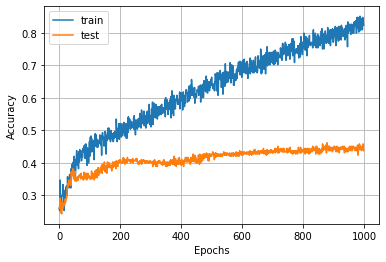

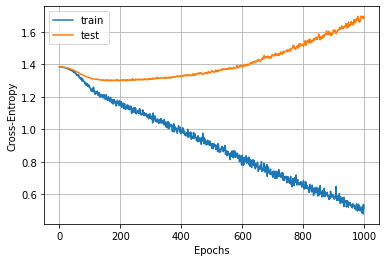


Resultados:
loss: [1.6184976763195462, 1.6936448282665677]
accuracy: [0.4375, 0.4375]
kappa: [0.25, 0.25]
Tiempo: 85.74438095092773


In [18]:
inicio = time.time()
array_loss = []
array_acc = []
array_kappa = []
for i in range(2):
  print("Iteration:", i+1)
    
  model = CNN_2D()

  '''history = model.fit_generator(datagen_train.flow(x_train, y_train_categorical, batch_size=36),
                                steps_per_epoch=np.ceil(n_samples_train/36),
                                epochs=1000,
                                validation_data=(x_test, y_test_categorical),
                                verbose=0) #, callbacks=[mc])
  
  test_loss, test_acc = model.evaluate(x_test, y_test_categorical, verbose=0)'''

  history = model.fit(x_train, y_train, epochs=1000, batch_size=36,
                      validation_data=(x_test, y_test), verbose=0)
    
  test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
  array_loss.append(test_loss)
  print("loss: ", test_loss)
  array_acc.append(test_acc)
  print("accuracy: ", test_acc)
    
  probabilidades = model.predict(x_test)
  y_pred = np.argmax(probabilidades, 1) #1=fila
    
  kappa = cohen_kappa_score(y_test, y_pred)
  array_kappa.append(kappa)
  print("kappa: ", kappa)
    
  matriz_confusion = confusion_matrix(y_test, y_pred)
  print("confusion matrix:\n", matriz_confusion)
    
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['train', 'test'])
  plt.show()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Cross-Entropy')
  plt.legend(['train', 'test'])
  plt.show()
    
print() 
print("Resultados:")
print("loss:", array_loss)
print("accuracy:", array_acc)
print("kappa:", array_kappa)
fin = time.time()
print("Tiempo:", fin - inicio)

In [19]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 264, 4, 16)        160       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 132, 2, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 132, 2, 16)        2320      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 66, 1, 16)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1056)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               135296    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)              

In [20]:
print("Mean Accuracy: %.4f" % np.mean(array_acc))
print("std: (+/- %.4f)" % np.std(array_acc))
print("Mean Kappa: %.4f" % np.mean(array_kappa))
print("std: (+/- %.4f)" % np.std(array_kappa))
print("Max Accuracy: %.4f" % np.max(array_acc))
print("Max Kappa: %.4f" % np.max(array_kappa))

Mean Accuracy: 0.4375
std: (+/- 0.0000)
Mean Kappa: 0.2500
std: (+/- 0.0000)
Max Accuracy: 0.4375
Max Kappa: 0.2500


In [24]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sun Jun  7 03:07:27 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    32W / 250W |    619MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# Sujeto 1
# sin DA = 56%
# con DA = 53%
# red de antes = 55%
# red de antes con 264x8 = 56%
# -----red de antes sin DA= 57%-----
# red de antes sin DA con 264x8 = 54%
# red de antes sin DA con 264x8 con filtros de 12x3 = 50.35%

# Sujeto 3
# red de antes sin DA= 65.10%

# Sujeto 6
# red de antes sin DA= 43.75%